# Running notebooks as hybrid jobs with Amazon Braket

In this notebook, we show how users can run notebooks on different quantum hardware with priority access by using Amazon Braket Hybrid Jobs.

This tutorial runs the introductory notebook "src/0_Getting_started_papermill.ipynb" on three different QPUs and SV1 simulator.


## Step 1. Add parameters to the input notebook 

The first step is to add [Papermill](https://papermill.readthedocs.io/en/latest/) parameters to the notebook you want to run. In this example, we will run *"src/0_Getting_started_papermill.ipynb"*. 
In the top cell, we add a tag called "parameters" with three values: `shots`, `device_arn`, and `results_dir`. 

The shots parameter is recorded as a hyperparameter in jobs. These are for user-specified parameters that are effect the algorithm in the notebook. The parameters are passed to a job with the keyword argument `hyperparameters={"shots": 1_000}`. 

The Braket specific parameters are `device_arn` and `results dir`. The `device_arn` allows users to choose a QPU to run the a notebook on with priority access to the QPUs for the duration of the job. 

The `results_dir` parameters is not adjustable, but rather a requirement for Braket Jobs to save the output in the correct Amazon S3 bucket. Any saved outputs in the notebook must specify the results directory path. For example, in the input notebook, the bottom cell saves a figure to the result directory.

Below is a screenshot from top of the input notebook: 

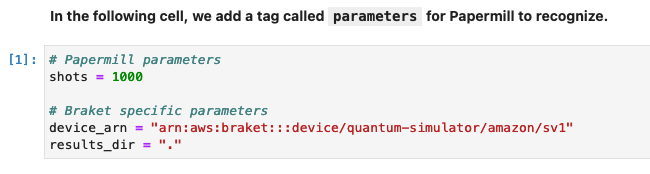

## Step 2. [Optional] Append `results_dir` to any files to save 

To save files, we need to add `results_dir` to the name of any files that are saved. In the example provided, the bottom cell of the input notebook is:

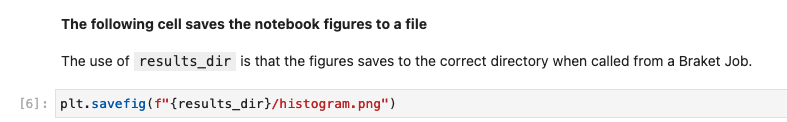

## Step 3. Choose hyperparameters and device

In the following cell, we specify the hyperparameter `shots` as a Python dictionary. These hyperparameters will overwrite any default values in the parameters cell of the target notebook. We also choose the device ARN to be the SV1 simulator on Amazon Braket. 

In [1]:
device_arn = "arn:aws:braket:::device/quantum-simulator/amazon/sv1"

hyperparameters = {"shots": 1_000}

## Step 4. Create a hyrbid job with the input notebook

The notebook to run is specified in `input_data` when creating a job. The entry point is the helper script "src.notebook_runner:run_notebook` which uses the Python library Papermill to run the notebook. 

In [2]:
import time

from braket.aws import AwsQuantumJob
from braket.jobs.local import LocalQuantumJob

job = AwsQuantumJob.create(
    device=device_arn,
    source_module="src",
    entry_point="src.notebook_runner:run_notebook",
    input_data="src/0_Getting_started_papermill.ipynb",
    hyperparameters=hyperparameters,
    job_name=f"papermill-job-demo-{int(time.time())}",
)

# Print job to record the ARN
print(job)

AwsQuantumJob('arn':'arn:aws:braket:<region>:<account_id>:job/papermill-job-demo-1681481374')


## Step 5. [Optional] Check job state

Next, wait for the job to complete. 
When it finishes, the following cell with return `COMPLETED`.

In [3]:
job.state()

'QUEUED'

## Step 6. Download the results

You can download the results and output notebook to a local directory using the `download_result` function. 

In [4]:
job.download_result("result")

In [6]:
time.sleep(10)  #  wait for metrics to load

metrics = job.metrics()
cost = metrics["cost"][0]

print(f"Braket task cost: ${cost} USD")

Braket task cost: $0.00375 USD


Now there should be a file called `0_Getting_started_papermill.ipynb` in the result directory. This notebook was run with `hyperparameters` within the Braket job. 

We can also see that the `0_Getting_started_papermill.ipynb` saved the histogram figure as a PNG file. 

## Step 7. View the output notebook

The output notebook and any other files will be downloaded to the `dir_name` directory. In this example, it's a folder called "result". 

When opening the output notebook, notice that the Papermill parameters have been overwritten. 

Below is a cell from the output notebook.

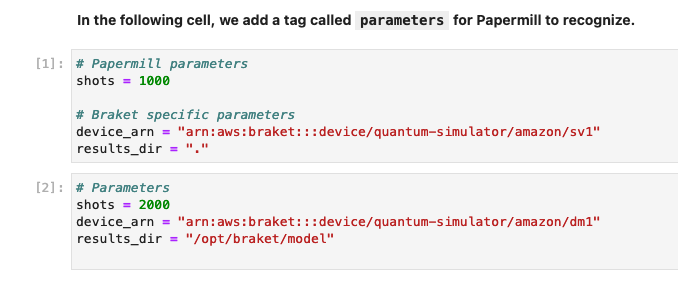


# Running a notebook on multiple QPUs

As a next step, we can run the same notebook on different devices. Below, we select four devices to run the notebook on. 

In [7]:
# Uncomment to run on real QPUs. Charges will apply.
devices = [
    "arn:aws:braket:::device/quantum-simulator/amazon/sv1",
    # "arn:aws:braket:us-west-1::device/qpu/rigetti/Aspen-M-3",
    # "arn:aws:braket:<region>::device/qpu/oqc/Lucy",
    # "arn:aws:braket:us-east-1::device/qpu/ionq/Harmony",
]

We create the jobs and record the job ARNs for reference later.  

<div class="alert alert-block alert-info">
<b>Note:</b> The following cell runs on QPUS and simulators. Charges will apply. The estimated cost for the following cell is $11.60 USD, and may take 24h to complete.
</div>

In [8]:
jobs = []
for device_arn in devices:
    device_name = device_arn.split("/")[-1]
    job = AwsQuantumJob.create(
        device=device_arn,
        source_module="src",
        entry_point="src.notebook_runner:run_notebook",
        input_data="src/0_Getting_started_papermill.ipynb",
        hyperparameters={"shots": 1_000},
        job_name=f"{device_name.lower()}",
    )
    print(job)
    jobs.append(job)

AwsQuantumJob('arn':'arn:aws:braket:<region>:<account_id>:job/sv1')
AwsQuantumJob('arn':'arn:aws:braket:<region>:<account_id>:job/aspen-m-3')
AwsQuantumJob('arn':'arn:aws:braket:<region>:<account_id>:job/lucy')
AwsQuantumJob('arn':'arn:aws:braket:<region>:<account_id>:job/ionqdevice')


The QPU jobs will run when the device is available. This may take up to 24 hours depending on the availability windows of the devices and when the jobs are created.

After the jobs are completed, use the `download_result_notebook` function to download the results. The cost per notebook was recorded as a jobs metrics which is also included in the code below. 

In [10]:
# After submitting them, wait for all jobs to complete and download results.
total_cost = 0
for job, device_arn in zip(jobs, devices):
    device_name = device_arn.split("/")[-1]

    job.download_result("result")

    metrics = job.metrics()
    cost = metrics["cost"][0]

    print(f"\nDevice: {device_name}")
    print(f"Cost was : ${cost} USD")

    total_cost += cost

In [ ]:
print(f"Total cost for all notebook jobs was : ${total_cost:0.4} USD")

Total cost was : $11.6 USD


In [9]:
# # Combining all Plots
# import pickle

# import matplotlib.pyplot as plt

# fig, axs = plt.subplots(1, 4, sharey=True, figsize=(10, 3))
# colors = ["tab:blue", "tab:cyan", "tab:gray", "tab:orange"]

# for i, (c, device_arn) in enumerate(zip(colors, devices)):
#     device_name = device_arn.split("/")[-1]
#     with open(f"result/{device_name.lower()}/results.pkl", "rb") as file:
#         counts = pickle.load(file)
#     axs[i].bar(counts.keys(), counts.values(), color=c)
#     axs[i].set(xlabel="bitstrings", title=f"{device_name}")
# axs[0].set(ylabel="counts")
# plt.show()

The results from running the Bell state on three QPU and SV1 is shown below. 

![](result/output.png)